## Traffic Forecasting Research Plan (Phase 1)
## Model Strategy, Evaluation Metrics, and Selection Criteria

### Objective
To identify the most accurate and robust model for traffic flow forecasting using real-world traffic sensor data. The best model will later feed into EV charging coordination simulations for improving power system resilience.

---

## Modeling Strategy

We will compare **9 models** across 4 categories:

| Category                    | Models |
|----------------------------|--------|
| **Baseline Models**        | Linear Regression, LSTM-only |
| **Published Hybrid Model** | CNN-GRU-LSTM (from literature) |
| **Graph-based Models**     | DCRNN-only, STGCN-only, GraphWaveNet-only |
| **Proposed Hybrid Models** | DCRNN-GRU-LSTM, STGCN-GRU-LSTM, GraphWaveNet-GRU-LSTM |

---

## Model Rationales

**1. Baseline Models**
- *Linear Regression*: Simple, interpretable benchmark.
- *LSTM-only*: Captures temporal patterns without spatial structure.

**2. CNN-GRU-LSTM (Literature Benchmark)**
- Combines CNN (spatial features) + GRU + LSTM (short and long-term temporal dependencies).
- Reproduced from a recent paper for benchmarking.

**3. Graph-based Models**
- *DCRNN*: Diffusion convolution (directed graphs) + RNNs.
- *STGCN*: Chebyshev graph convolution + temporal convolution.
- *GraphWaveNet*: Adaptive graph learning + dilated causal convolutions.

**4. Proposed Hybrid Models**
- Combines graph-based spatial modules with GRU and LSTM layers to leverage deep spatial-temporal dependencies.

---

## Forecasting Horizon

We forecast traffic **72 hours ahead (3 days)** using multi-output models. This helps evaluate short- and medium-term predictive accuracy.

- Models will be trained to predict:
  - The next **12, 24 hours**,
  - And the next **48, 72 hours** ahead.

---

## Evaluation Metrics

We will use **three key metrics** for model comparison:

- **MAPE (Mean Absolute Percentage Error)**: 
  - Interpretable percentage error.
- **RMSE (Root Mean Squared Error)**: 
  - Penalizes larger errors more heavily.
- **MAE (Mean Absolute Error)**: 
  - Stable average error measure.

All models will be evaluated on the same test set using these metrics at both 24h and 72h forecasting horizons.

---

## Model Selection Criteria

Final model will be selected based on:

1. **Lowest RMSE, MAE, and MAPE** on test data.
2. **Spatial consistency**: Station-level errors should not vary drastically.
3. **Generalization ability**: Minimal overfitting (close validation and test performance).
4. **Efficiency** *(secondary)*: Preference for simpler or faster models if performance is tied.

---

## Input Features (Used Across All Models)

To ensure a fair comparison, all 9 models will use the same feature set:

- **Temporal Features**: hour, day, month, weekday, holiday flags.
- **Lag Features**: Flow_lag_1 to Flow_lag_72.
- **Sliding Window Stats**: rolling mean, min, max, std.
- **Cyclical Features**: sine/cosine of time variables.
- **Graph Features**:
  - *DCRNN*: fixed adjacency matrix from CV clustering.
  - *STGCN*: Chebyshev-based graph structure.
  - *GraphWaveNet*: learns the adjacency dynamically.

---

## Summary

- Compare 9 models (baseline, benchmark, graph-based, hybrid).
- Forecast 24h and 72h ahead.
- Use MAPE, RMSE, MAE as evaluation metrics.
- Select best model for downstream EV charging coordination.


In [14]:
import pandas as pd
import glob
import os
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import  Dropout
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
df = pd.read_csv(r"C:\Users\attafuro\Desktop\EV Charging Analysis\cleaned_traffic_data.csv")

In [3]:
df. head()

,Timestamp,Station,District,Route,Direction of Travel,Lane Type,Station Length,Samples,% Observed,Total Flow,...,Lane 5 Avg Speed,Lane 6 Flow,Lane 6 Avg Occ,Lane 6 Avg Speed,Lane 7 Flow,Lane 7 Avg Occ,Lane 7 Avg Speed,Lane 8 Flow,Lane 8 Avg Occ,Lane 8 Avg Speed
0,10/01/2024 00:00:00,308512,3,50,W,ML,3.995,197,0,497.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10/01/2024 00:00:00,311831,3,5,S,OR,NaN,101,92,27.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10/01/2024 00:00:00,311832,3,5,S,FR,NaN,101,92,78.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10/01/2024 00:00:00,311844,3,5,N,OR,NaN,202,92,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10/01/2024 00:00:00,311847,3,5,N,OR,NaN,303,92,73.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Define the final selected columns
selected_columns = [
    "Timestamp", "Station", "Route", "Direction of Travel",
    "Total Flow", "Avg Speed", "% Observed","Samples","Lane Type"
]

# Keep only the selected columns
df = df[selected_columns]

In [5]:
df.head()

,Timestamp,Station,Route,Direction of Travel,Total Flow,Avg Speed,% Observed,Samples,Lane Type
0,10/01/2024 00:00:00,308512,50,W,497.0,64.1,0,197,ML
1,10/01/2024 00:00:00,311831,5,S,27.0,NaN,92,101,OR
2,10/01/2024 00:00:00,311832,5,S,78.0,NaN,92,101,FR
3,10/01/2024 00:00:00,311844,5,N,43.0,NaN,92,202,OR
4,10/01/2024 00:00:00,311847,5,N,73.0,NaN,92,303,OR


In [7]:
df.isna().sum()

Timestamp                    0
Station                      0
Route                        0
Direction of Travel          0
Total Flow              303776
Avg Speed              1582594
% Observed                   0
Samples                      0
Lane Type                    0
dtype: int64

In [8]:
df.drop(columns=["Avg Speed"], inplace=True)

In [9]:
df.head()

,Timestamp,Station,Route,Direction of Travel,Total Flow,% Observed,Samples,Lane Type
0,10/01/2024 00:00:00,308512,50,W,497.0,0,197,ML
1,10/01/2024 00:00:00,311831,5,S,27.0,92,101,OR
2,10/01/2024 00:00:00,311832,5,S,78.0,92,101,FR
3,10/01/2024 00:00:00,311844,5,N,43.0,92,202,OR
4,10/01/2024 00:00:00,311847,5,N,73.0,92,303,OR


In [10]:
df.isna().sum()

Timestamp                   0
Station                     0
Route                       0
Direction of Travel         0
Total Flow             303776
% Observed                  0
Samples                     0
Lane Type                   0
dtype: int64

In [11]:
df = df[df['Total Flow'].notna()]

In [12]:
df.isna().sum()

Timestamp              0
Station                0
Route                  0
Direction of Travel    0
Total Flow             0
% Observed             0
Samples                0
Lane Type              0
dtype: int64

In [13]:
df.head()

,Timestamp,Station,Route,Direction of Travel,Total Flow,% Observed,Samples,Lane Type
0,10/01/2024 00:00:00,308512,50,W,497.0,0,197,ML
1,10/01/2024 00:00:00,311831,5,S,27.0,92,101,OR
2,10/01/2024 00:00:00,311832,5,S,78.0,92,101,FR
3,10/01/2024 00:00:00,311844,5,N,43.0,92,202,OR
4,10/01/2024 00:00:00,311847,5,N,73.0,92,303,OR


In [16]:
df.dtypes

Timestamp               object
Station                  int64
Route                    int64
Direction of Travel     object
Total Flow             float64
% Observed               int64
Samples                  int64
Lane Type               object
dtype: object

In [17]:
df.duplicated().sum()

0

In [18]:
df.reset_index().duplicated(subset=['Timestamp', 'Station']).sum()

0

In [19]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)
df.sort_index(inplace=True)

In [21]:
df.head()

,Station,Route,Direction of Travel,Total Flow,% Observed,Samples,Lane Type
Timestamp,,,,,,,
2024-10-01,308512,50,W,497.0,0,197,ML
2024-10-01,311831,5,S,27.0,92,101,OR
2024-10-01,311832,5,S,78.0,92,101,FR
2024-10-01,311844,5,N,43.0,92,202,OR
2024-10-01,311847,5,N,73.0,92,303,OR


In [22]:
df['Hour'] = df.index.hour
df['Day'] = df.index.day
df['Weekday'] = df.index.weekday
df['IsWeekend'] = df['Weekday'].isin([5, 6]).astype(int)

In [23]:
for lag in range(1, 73):  # Lags 1 to 72
    df[f'TotalFlow_lag_{lag}'] = df['Total Flow'].shift(lag)

# Drop the rows that now have NaNs in these lag features (first 72 rows)
df.dropna(inplace=True)

In [24]:
df.head()

,Station,Route,Direction of Travel,Total Flow,% Observed,Samples,Lane Type,Hour,Day,Weekday,...,TotalFlow_lag_63,TotalFlow_lag_64,TotalFlow_lag_65,TotalFlow_lag_66,TotalFlow_lag_67,TotalFlow_lag_68,TotalFlow_lag_69,TotalFlow_lag_70,TotalFlow_lag_71,TotalFlow_lag_72
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-10-01,312652,99,N,64.0,92,303,OR,0,1,1,...,16.0,1042.0,15.0,549.0,1198.0,73.0,43.0,78.0,27.0,497.0
2024-10-01,312689,51,N,601.0,92,395,ML,0,1,1,...,1042.0,16.0,1042.0,15.0,549.0,1198.0,73.0,43.0,78.0,27.0
2024-10-01,312694,51,N,799.0,92,404,ML,0,1,1,...,782.0,1042.0,16.0,1042.0,15.0,549.0,1198.0,73.0,43.0,78.0
2024-10-01,312706,51,N,60.0,92,202,OR,0,1,1,...,23.0,782.0,1042.0,16.0,1042.0,15.0,549.0,1198.0,73.0,43.0
2024-10-01,312709,51,N,59.0,92,202,FR,0,1,1,...,957.0,23.0,782.0,1042.0,16.0,1042.0,15.0,549.0,1198.0,73.0


In [26]:
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
df['Weekday_sin'] = np.sin(2 * np.pi * df['Weekday'] / 7)
df['Weekday_cos'] = np.cos(2 * np.pi * df['Weekday'] / 7)

In [27]:
df['Flow_roll_mean_6h'] = df['Total Flow'].rolling(window=6).mean()
df['Flow_roll_std_6h'] = df['Total Flow'].rolling(window=6).std()
df['Flow_roll_max_6h'] = df['Total Flow'].rolling(window=6).max()
df['Flow_roll_min_6h'] = df['Total Flow'].rolling(window=6).min()

In [44]:
for window in [3, 12, 24, 48, 72]:
    df[f'Flow_mean_{window}'] = df['Total Flow'].rolling(window=window).mean()
    df[f'Flow_std_{window}'] = df['Total Flow'].rolling(window=window).std()
    df[f'Flow_min_{window}'] = df['Total Flow'].rolling(window=window).min()
    df[f'Flow_max_{window}'] = df['Total Flow'].rolling(window=window).max()

In [45]:
df.dropna(inplace=True)

In [35]:
custom_holidays = [
    pd.to_datetime("2024-12-25"),
    pd.to_datetime("2024-12-31"),
    pd.to_datetime("2024-11-24"),
]
df['IsHoliday'] = df.index.to_series().apply(lambda x: 1 if x in custom_holidays else 0)

In [46]:
df.head()

,Station,Route,Direction of Travel,Total Flow,% Observed,Samples,Lane Type,Hour,Day,Weekday,...,Flow_min_24,Flow_max_24,Flow_mean_48,Flow_std_48,Flow_min_48,Flow_max_48,Flow_mean_72,Flow_std_72,Flow_min_72,Flow_max_72
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-10-01,314230,50,W,140.0,92,202,ML,0,1,1,...,10.0,1223.0,368.458333,390.076259,10.0,1360.0,451.055556,383.842026,2.0,1379.0
2024-10-01,314231,50,W,5.0,92,202,OR,0,1,1,...,5.0,1223.0,340.229167,365.017997,5.0,1223.0,442.513889,386.860494,2.0,1379.0
2024-10-01,314241,50,W,142.0,92,302,ML,0,1,1,...,5.0,1223.0,323.250000,354.522244,5.0,1223.0,430.611111,382.658696,2.0,1379.0
2024-10-01,314242,50,W,56.0,92,202,OR,0,1,1,...,5.0,1223.0,302.708333,340.269290,5.0,1223.0,420.583333,382.887096,2.0,1379.0
2024-10-01,314248,50,E,439.0,92,302,ML,0,1,1,...,5.0,1223.0,304.020833,340.679264,5.0,1223.0,415.402778,380.029267,2.0,1379.0


In [49]:
for window in [12, 24, 48, 72]:
    df[f'Flow_CV_{window}'] = df[f'Flow_std_{window}'] / df[f'Flow_mean_{window}']

In [50]:
df.dropna(inplace=True)

In [51]:
# Group by station and calculate mean and std of Total Flow
station_stats = df.groupby('Station')['Total Flow'].agg(['mean', 'std'])
station_stats['CV'] = station_stats['std'] / station_stats['mean']
station_stats.dropna(inplace=True)  

In [52]:
df.head()

,Station,Route,Direction of Travel,Total Flow,% Observed,Samples,Lane Type,Hour,Day,Weekday,...,Flow_min_48,Flow_max_48,Flow_mean_72,Flow_std_72,Flow_min_72,Flow_max_72,Flow_CV_12,Flow_CV_24,Flow_CV_48,Flow_CV_72
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-10-01,314230,50,W,140.0,92,202,ML,0,1,1,...,10.0,1360.0,451.055556,383.842026,2.0,1379.0,1.118489,1.447079,1.058671,0.850986
2024-10-01,314231,50,W,5.0,92,202,OR,0,1,1,...,5.0,1223.0,442.513889,386.860494,2.0,1379.0,1.315346,1.529774,1.072859,0.874234
2024-10-01,314241,50,W,142.0,92,302,ML,0,1,1,...,5.0,1223.0,430.611111,382.658696,2.0,1379.0,1.182912,1.556574,1.096743,0.888641
2024-10-01,314242,50,W,56.0,92,202,OR,0,1,1,...,5.0,1223.0,420.583333,382.887096,2.0,1379.0,1.162419,1.620481,1.124083,0.910372
2024-10-01,314248,50,E,439.0,92,302,ML,0,1,1,...,5.0,1223.0,415.402778,380.029267,2.0,1379.0,1.109133,1.491311,1.120579,0.914845


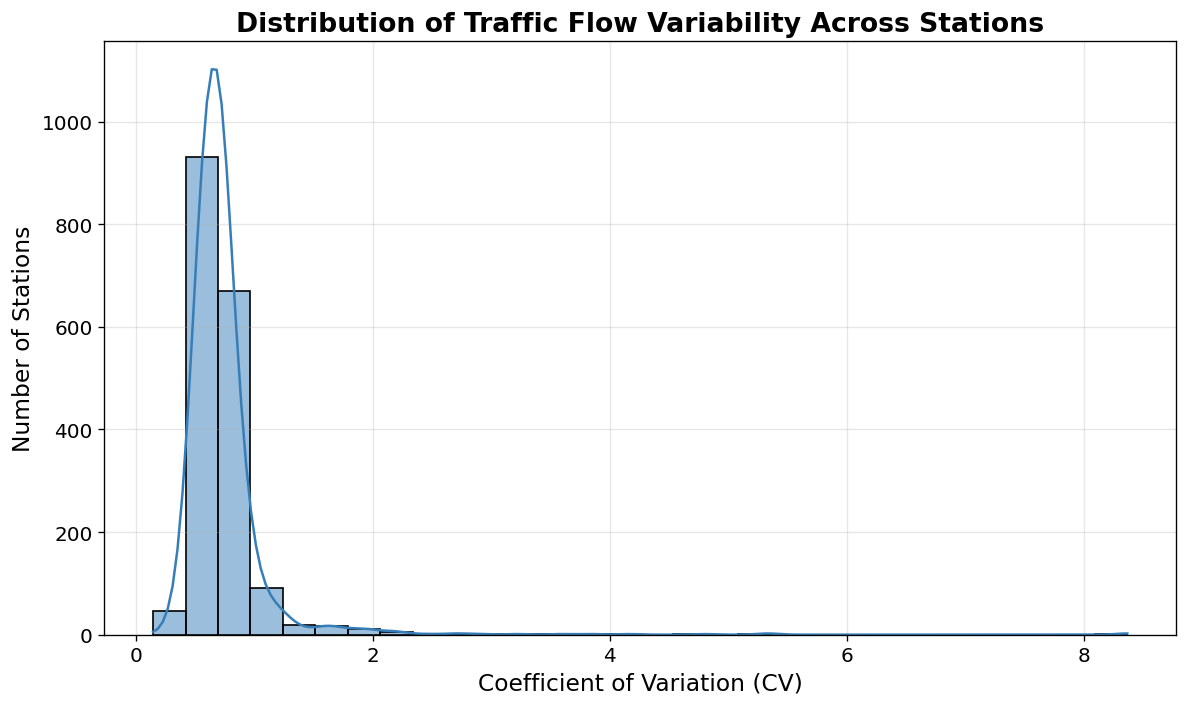

In [54]:
plt.figure(figsize=(10, 6), dpi=120)
sns.histplot(station_stats['CV'], bins=30, kde=True, color="#377eb8", edgecolor="black")

plt.title('Distribution of Traffic Flow Variability Across Stations', fontsize=16, fontweight='bold')
plt.xlabel('Coefficient of Variation (CV)', fontsize=14)
plt.ylabel('Number of Stations', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()